In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import tensorflow as tf
from tensorflow import keras

import pandas as pd
from pandas import read_csv

from sklearn.decomposition import PCA
import umap

import datetime

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers, initializers, regularizers, models, callbacks
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from sklearn.model_selection import train_test_split

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [59]:
def ksquare(x):
  return tf.pow(x, 2)

def klog(x):
  return tf.math.log(x)

In [4]:
# Convert from 64 to 32 bit floats
X_test = np.load("/home/alon/Projects/project/X_test.npy").astype(np.float32)
y_test = np.load("/home/alon/Projects/project/y_test.npy").astype(np.float32)
person_train_valid = np.load("/home/alon/Projects/project/person_train_valid.npy").astype(np.float32)
X_train_valid = np.load("/home/alon/Projects/project/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("/home/alon/Projects/project/y_train_valid.npy").astype(np.float32)
person_test = np.load("/home/alon/Projects/project/person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


In [7]:
#get indices
indices_train_val = np.arange(0, person_train_valid.shape[0])
print(indices_train_val)

#split training and validation data:
X_train, X_valid, y_train, y_valid, indices_train, indices_val = train_test_split(X_train_valid, y_train_valid, indices_train_val, test_size=0.2, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)

person_train = person_train_valid[indices_train]
person_valid = person_train_valid[indices_val]

print ('Training/Valid data shape: {}'.format(X_train.shape))
print ('Validation data shape: {}'.format(X_valid.shape))
print ('Training/Valid target shape: {}'.format(y_train.shape))
print ('Validation target shape: {}'.format(y_valid.shape))
print ('Training target shape: {}'.format(indices_train.shape))
print ('Validation target shape: {}'.format(indices_val.shape))

[   0    1    2 ... 2112 2113 2114]
Training/Valid data shape: (1692, 22, 1000)
Validation data shape: (423, 22, 1000)
Training/Valid target shape: (1692,)
Validation target shape: (423,)
Training target shape: (1692,)
Validation target shape: (423,)


In [8]:
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

In [9]:
#convert all vectors to one-hot
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_train_1h = convert_to_one_hot(y_train)
y_valid_1h = convert_to_one_hot(y_valid)
y_test_1h = convert_to_one_hot(y_test)

person_train_valid_1h = convert_to_one_hot(person_train_valid)
person_train_1h = convert_to_one_hot(person_train)
person_valid_1h = convert_to_one_hot(person_valid)
person_test_1h = convert_to_one_hot(person_test)

In [ ]:
# #instantiate and initialize pandas dataframes

# columns = ['subject_ix', 'subject_one_hot', 'data_22ch', 'event_class_ix', 'event_class_one_hot']

# train_val_df = pd.DataFrame(columns=columns)
# train_val_df['subject_ix'] = person_train_valid.reshape((person_train_valid.shape[0],))
# train_val_df['subject_one_hot'] = person_train_valid_1h.tolist()
# train_val_df['event_class_ix'] = y_train_valid
# train_val_df['event_class_one_hot'] = y_train_valid_1h.tolist()
# train_val_df['data_22ch'] = X_train_valid.tolist()

# test_df = pd.DataFrame(columns=columns)
# test_df['subject_ix'] = person_test.reshape((person_test.shape[0],))
# test_df['subject_one_hot'] = person_test_1h.tolist()
# test_df['event_class_ix'] = y_test
# test_df['event_class_one_hot'] = y_test.tolist()
# test_df['data_22ch'] = X_test.tolist()

In [10]:
#normalizing and then adding noise to every single training input

X_train_valid_norm = np.zeros_like(X_train_valid)

for eeg_ix in range(X_train_valid.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_train_valid[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_train_valid_norm[eeg_ix,i,:] = z

In [11]:
#normalizing and then adding noise to every single training input

X_train_norm = np.zeros_like(X_train)

for eeg_ix in range(X_train.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_train[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_train_norm[eeg_ix,i,:] = z

In [12]:
#validation data as well
X_valid_norm = np.zeros_like(X_valid)

for eeg_ix in range(X_valid.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_valid[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_valid_norm[eeg_ix,i,:] = z

In [13]:
#normalizing and then adding noise to every single test input

X_test_norm = np.zeros_like(X_test)

for eeg_ix in range(X_test.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_test[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_test_norm[eeg_ix,i,:] = z

In [29]:
#Crop for 12

X_train_valid_norm_cropped = X_train_valid_norm[:,:,:500]
X_train_norm_cropped = X_train_norm[:,:,:500]
X_valid_norm_cropped = X_valid_norm[:,:,:500]
X_test_norm_cropped = X_test_norm[:,:,:500]

Text(0.5, 1.0, 'CDF of Actions in Test Set')

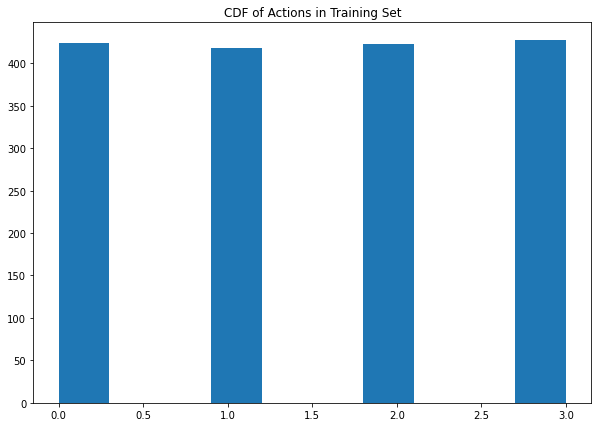

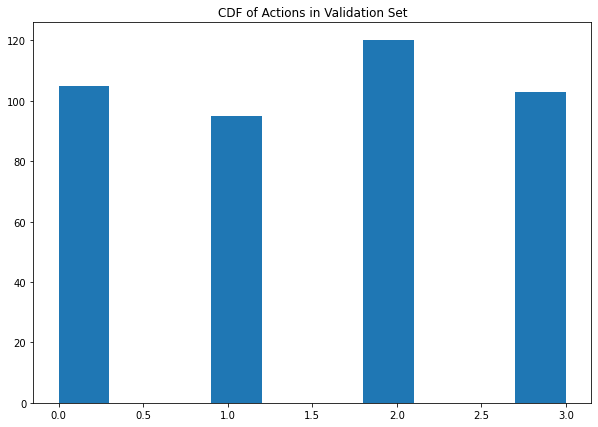

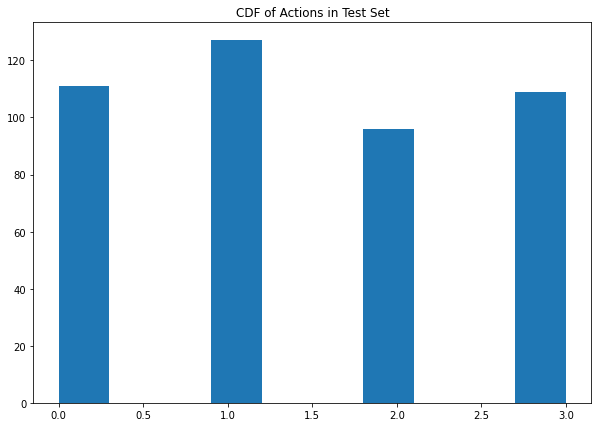

In [30]:
#want to see the distribution of actions, subjects
plt.figure(figsize=(10,7))
actions_hist_train = plt.hist(y_train)
plt.title("CDF of Actions in Training Set")

plt.figure(figsize=(10,7))
actions_hist_train = plt.hist(y_valid)
plt.title("CDF of Actions in Validation Set")

plt.figure(figsize=(10,7))
actions_hist_train = plt.hist(y_test)
plt.title("CDF of Actions in Test Set")

In [33]:
#instantiate and initialize pandas dataframes

columns = ['subject_ix', 'subject_one_hot', 'data_22ch', 'event_class_ix', 'event_class_one_hot']

train_df = pd.DataFrame(columns=columns)
train_df['subject_ix'] = person_train.reshape((person_train.shape[0],))
train_df['subject_one_hot'] = person_train_1h.tolist()
train_df['event_class_ix'] = y_train
train_df['event_class_one_hot'] = y_train_1h.tolist()
train_df['data_22ch'] = X_train.tolist()
train_df['data_22ch_norm_crop'] = X_train_norm_cropped.tolist()

valid_df = pd.DataFrame(columns=columns)
valid_df['subject_ix'] = person_valid.reshape((person_valid.shape[0],))
valid_df['subject_one_hot'] = person_valid_1h.tolist()
valid_df['event_class_ix'] = y_valid
valid_df['event_class_one_hot'] = y_valid_1h.tolist()
valid_df['data_22ch'] = X_valid.tolist()
valid_df['data_22ch_norm_crop'] = X_valid_norm_cropped.tolist()

test_df = pd.DataFrame(columns=columns)
test_df['subject_ix'] = person_test.reshape((person_test.shape[0],))
test_df['subject_one_hot'] = person_test_1h.tolist()
test_df['event_class_ix'] = y_test
test_df['event_class_one_hot'] = y_test.tolist()
test_df['data_22ch'] = X_test.tolist()
test_df['data_22ch_norm_crop'] = X_test_norm_cropped.tolist()

In [82]:
train_df[train_df['subject_ix']==7].index.values

array([   0,    1,   11,   17,   18,   20,   23,   40,   60,   79,   81,
         88,   91,  106,  110,  123,  132,  151,  158,  166,  171,  174,
        175,  180,  183,  222,  227,  228,  230,  234,  235,  236,  244,
        264,  269,  290,  296,  312,  316,  331,  335,  388,  392,  395,
        400,  419,  427,  428,  450,  460,  474,  485,  497,  509,  513,
        517,  526,  536,  539,  544,  567,  568,  571,  572,  573,  599,
        600,  605,  613,  614,  645,  653,  660,  668,  685,  686,  700,
        707,  708,  711,  724,  727,  736,  741,  749,  755,  792,  794,
        867,  870,  886,  887,  890,  896,  902,  916,  922,  936,  965,
        974,  988,  998,  999, 1003, 1007, 1018, 1036, 1049, 1050, 1054,
       1056, 1068, 1070, 1078, 1090, 1097, 1100, 1106, 1109, 1113, 1123,
       1125, 1128, 1131, 1137, 1173, 1180, 1199, 1206, 1267, 1271, 1309,
       1316, 1320, 1325, 1327, 1337, 1343, 1353, 1354, 1378, 1379, 1390,
       1406, 1414, 1420, 1434, 1446, 1459, 1462, 14

In [39]:
#n_comp = 18

#flip
X_train_flipped = np.transpose(X_train_norm_cropped, (0,2,1))
X_valid_flipped = np.transpose(X_valid_norm_cropped, (0,2,1))
X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))

print(X_train_flipped.shape)
print(X_valid_flipped.shape)
print(X_test_flipped.shape)

X_train_reshaped = X_train_flipped.reshape((X_train_norm_cropped.shape[0]*X_train_norm_cropped.shape[2], 22)) 
X_valid_reshaped = X_valid_flipped.reshape((X_valid_norm_cropped.shape[0]*X_valid_norm_cropped.shape[2], 22)) 
X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 

(1692, 500, 22)
(423, 500, 22)
(443, 500, 22)


In [40]:
n_comps = [15, 18, 20]

for n_comp in n_comps:
    #try a PCA on the training data
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_train_reshaped)                               #fit it to your transformed data
    X_train_transformed=np.empty([X_train_norm_cropped.shape[0],X_train_norm_cropped.shape[2],n_comp])
    for i in range(len(X_train_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_train_transformed[i]=pca.transform(X_train_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    print(X_train_transformed.shape)
    X_train_transformed = np.transpose(X_train_transformed, (0,2,1))
    print(X_train_transformed.shape)

    #now apply that transformation to the validation and test sets
    X_valid_transformed=np.empty([X_valid_norm_cropped.shape[0],X_valid_norm_cropped.shape[2],n_comp])
    X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])

    for i in range(len(X_valid_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_valid_transformed[i]=pca.transform(X_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    #print(X_train_transformed.shape)
    X_valid_transformed = np.transpose(X_valid_transformed, (0,2,1))
    print(X_valid_transformed.shape)

    for i in range(len(X_test_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    #print(X_train_transformed.shape)
    X_test_transformed = np.transpose(X_test_transformed, (0,2,1))
    print(X_test_transformed.shape)

    train_df['data_22ch_norm_crop_pca'+str(n_comp)] = X_train_transformed.tolist()
    valid_df['data_22ch_norm_crop_pca'+str(n_comp)] = X_valid_transformed.tolist()
    test_df['data_22ch_norm_crop_pca'+str(n_comp)] = X_test_transformed.tolist()

(1692, 500, 15)
(1692, 15, 500)
(423, 15, 500)
(443, 15, 500)
(1692, 500, 18)
(1692, 18, 500)
(423, 18, 500)
(443, 18, 500)
(1692, 500, 20)
(1692, 20, 500)
(423, 20, 500)
(443, 20, 500)


In [34]:
#examples of obtaining train_val and test dataframes from the larger dataframes

s0_train_df = train_df[train_df['subject_ix'] == 0]
s0_valid_df = valid_df[valid_df['subject_ix'] == 0]
s0_test_df = test_df[test_df['subject_ix'] == 0]

s1_train_df = train_df[train_df['subject_ix'] == 1]
s1_valid_df = valid_df[valid_df['subject_ix'] == 1]
s1_test_df = test_df[test_df['subject_ix'] == 1]

s2_train_df = train_df[train_df['subject_ix'] == 2]
s2_valid_df = valid_df[valid_df['subject_ix'] == 2]
s2_test_df = test_df[test_df['subject_ix'] == 2]

s3_train_df = train_df[train_df['subject_ix'] == 3]
s3_valid_df = valid_df[valid_df['subject_ix'] == 3]
s3_test_df = test_df[test_df['subject_ix'] == 3]

s4_train_df = train_df[train_df['subject_ix'] == 4]
s4_valid_df = valid_df[valid_df['subject_ix'] == 5]
s4_test_df = test_df[test_df['subject_ix'] == 4]

s5_train_df = train_df[train_df['subject_ix'] == 5]
s5_valid_df = valid_df[valid_df['subject_ix'] == 5]
s5_test_df = test_df[test_df['subject_ix'] == 5]

s6_train_df = train_df[train_df['subject_ix'] == 6]
s6_valid_df = valid_df[valid_df['subject_ix'] == 6]
s6_test_df = test_df[test_df['subject_ix'] == 6]

s7_train_df = train_df[train_df['subject_ix'] == 7]
s7_valid_df = valid_df[valid_df['subject_ix'] == 7]
s7_test_df = test_df[test_df['subject_ix'] == 7]

s8_train_df = train_df[train_df['subject_ix'] == 8]
s8_valid_df = valid_df[valid_df['subject_ix'] == 8]
s8_test_df = test_df[test_df['subject_ix'] == 8]

In [35]:
#example of grabbing the data from a given subject df
s0_X_train = np.array([[[value for value in ch] for ch in run] for run in s0_train_df['data_22ch_norm_crop'].values], ndmin=3)
s0_y_train = s0_train_df['subject_ix'].values

In [62]:
def get_X_data(df, n_dims=22):
    if n_dims == 22:
        return np.array([[[value for value in ch] for ch in run] for run in df['data_22ch_norm_crop'].values], ndmin=3)
    else:
        return np.array([[[value for value in ch] for ch in run] for run in df['data_22ch_norm_crop_pca'+str(n_dims)].values], ndmin=3)


In [66]:
#for example

s4_X_train = get_X_data(s4_train_df, 22)
print(s4_X_train.shape)

print(type(s4_X_train[0][10][8:50]))

(192, 22, 500)
<class 'numpy.ndarray'>


In [52]:
def get_model(n_timesteps=1000, drp=0.85, n_comp=22):
    input_ = layers.Input(shape=(n_comp, 500))
    r1 = layers.Reshape(target_shape=(n_comp, 500, 1))(input_)
    c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                       activation='elu', kernel_regularizer='l2')(r1)
    p1 = layers.Permute(dims=(2,1,3))(c1)
    r2 = layers.Reshape((476, n_comp*40))(p1)
    d1 = layers.Dense(40, activation='elu')(r2)
    sq1 = layers.Activation(ksquare)(d1)
    ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
    log1 = layers.Activation(klog)(ap1)
    f1 = layers.Flatten()(log1)
    d2 = layers.Dropout(drp)(f1)
    output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)

    model = models.Model(inputs=input_, outputs=output_, name='shallow_pca_convnet_one_hot')
    return model

In [53]:
def plot_train_hist(loss_hist):
    hist = loss_hist.history

    fig, axs = plt.subplots(1,2, figsize=(20, 12))

    fig.suptitle("Training results for dropout={} and n_dims={}".format(drp, n_comp), fontsize=14)

    axs[0].plot(hist['loss'])
    axs[0].plot(hist['val_loss'])
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'])

    axs[1].plot(hist['acc'])
    axs[1].plot(hist['val_acc'])
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'])

In [77]:
#Now let's train a model on the full-scale data for all subjects

for subject_ix in range(9):
    s_train_df = train_df[train_df['subject_ix'] == subject_ix]
    s_valid_df = valid_df[valid_df['subject_ix'] == subject_ix]
    s_test_df = test_df[test_df['subject_ix'] == subject_ix]
    
    s_X_train = np.array(get_X_data(s_train_df, 22))
    s_X_valid = get_X_data(s_valid_df, 22)
    s_X_test = get_X_data(s_test_df, 22)
    
    s_y_train = s_train_df['event_class_one_hot']
    s_y_valid = s_valid_df['event_class_one_hot']
    s_y_test = s_test_df['event_class_one_hot']
    
    print(type(s_y_train.values))
    
    model = get_model(n_timesteps=500, drp=0.85, n_comp=22)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    #mcp_save = callbacks.ModelCheckpoint('.mdl_wts_best_acc' + str(n_comp) + '_dims.hdf5',
                                         #save_best_only=True, monitor='val_acc', mode='max')
    
    loss_hist = model.fit(get_X_data(s_train_df, 22), s_y_train.values, epochs=150,
                          validation_data=(s_X_valid, s_y_valid.values),
                          callbacks=[], 
                          verbose=True)
    
    plot_train_hist(loss_hist)
    
    # Evaluate the model on the test data using `evaluate`
    #print("Evaluate final step on test data")
    results = model.evaluate(s_X_test, s_y_test, batch_size=32)
    print("final test loss, test acc:", results)

<class 'numpy.ndarray'>


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).